# The Red Line Problem

This notebook is based on an exercise in [Think Bayes, 2nd edition](https://greenteapress.com/wp/think-bayes/):

> The Red Line is a subway that connects Cambridge and Boston, Massachusetts. When I was working in Cambridge I took the Red Line from Kendall Square to South Station and caught the commuter rail to Needham. During rush hour Red Line trains run every 7–8 minutes, on average.
>
> When I arrived at the subway stop, I could estimate the time until the next train based on the number of passengers on the platform. If there were only a few people, I inferred that I just missed a train and expected to wait about 7 minutes. If there were more passengers, I expected the train to arrive sooner. But if there were a large number of passengers, I suspected that trains were not running on schedule, so I would leave the subway stop and get a taxi.
>
> While I was waiting for trains, I thought about how Bayesian inference could help predict my wait time and decide when I should give up and take a taxi. This example presents the analysis I came up with.

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate

Before we get to the analysis, we have to make some modeling decisions. First, I will treat passenger arrivals as a Poisson process, which means I assume that passengers are equally likely to arrive at any time, and that they arrive at a rate, λ, measured in passengers per minute. Since I observe passengers during a short period of time, and at the same time every day, I assume that λ is constant.

On the other hand, the arrival process for trains is not Poisson. Trains to Boston are supposed to leave from the end of the line (Alewife station) every 7–8 minutes during peak times, but by the time they get to Kendall Square, the time between trains varies between 3 and 12 minutes.

To gather data on the time between trains, I wrote a script that downloads real-time data from the [MBTA](http://www.mbta.com/rider_tools/developers/), selects south-bound trains arriving at Kendall Square, and records their arrival times in a database. I ran the script from 4 pm to 6 pm every weekday for 5 days, and recorded about 15 arrivals per day. Then I computed the time between consecutive arrivals.
Here are the gap times I recorded, in seconds.

In [4]:
observed_gap_times = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]) / 60

I'll use KDE to estimate the distribution of gap times.

In [5]:
from scipy.stats import gaussian_kde

kde_gap = gaussian_kde(observed_gap_times)

If you arrive at the station at a random time, you are more likely to arrive during a long gap than a small one.
To estimate the distribution of gap times -- as seen by a random arrival -- we can use KDE again, with the gap times themselves as weights.
For more about this kind of length-biased sampling, see Chapter 2 of [*Probably Overthinking It*](https://probablyoverthinking.it).

In [6]:
kde_prior = gaussian_kde(observed_gap_times, weights=observed_gap_times)

Here's what these distributions look like -- the actual distribution of times between trains and the observed distribution as seen by a random arrival.

In [7]:
def plot_kde(kde, **options):
    xs = np.linspace(0, 20, 101)
    ps = kde(xs)
    plt.plot(xs, ps, **options) 

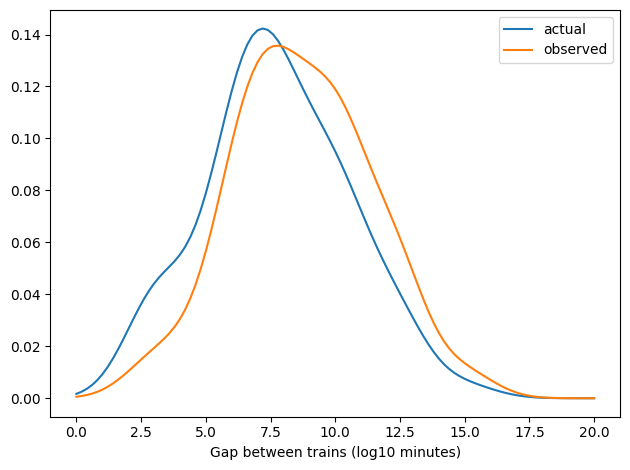

In [8]:
plot_kde(kde_gap, label='actual')
plot_kde(kde_prior, label='observed')

decorate(xlabel='Gap between trains (log10 minutes)')

## Model 1: KDE prior of gap times

Since we have a sample from the prior, one option is to use KDE to construct the prior distribution of gap times, as seen by a random arrival.

The following function takes the sample and returns an `Interpolated` object that represents the prior.
For the sampler to behave well, we need to evaluate the estimated density far enough into the tails to make a smooth transition down to 0.

In [9]:
# Modified version based on the example at
# from https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html

def kde_from_sample(name, sample):
    m = np.mean(sample)
    s = np.std(sample)
    low, high = np.min(sample), np.max(sample)
    
    x = np.linspace(0, high+s, 101)
    y = gaussian_kde(sample)(x)

    # pad the domain with zeros
    x = np.concatenate([[x[0] - 3 * s], x, [x[-1] + 3 * s]])
    y = np.concatenate([[0], y, [0]])
    
    return pm.Interpolated(name, x, y)

Here's a model that uses that prior of gap times and a normal model for the arrival rate, with a small standard deviation, indicating that we have precise information about arrival rates.

In [10]:
import pymc as pm  

# gap_time: interpolated
# rate: Normal

def make_model1(n_obs=10):
    """Make a model of the red line problem.
    
    n_obs: observed passengers
    """
    model = pm.Model()
    with model:
        gap_time = kde_from_sample('gap_time', observed_gap_times)
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Normal('rate', mu=2, sigma=0.1)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 2: Normal prior of gap times

The KDE prior might be most faithful to the data, but it probably includes details of the sample that are not generalizable.
It might be just as reasonable to use a normal prior, and it might improve the performance of the sampler.

To see how good the model it, we can use the estimated density to compute a CDF.

In [70]:
from empiricaldist import Pmf

xs = np.linspace(0.01, 25, 101)
ps = kde_prior.evaluate(xs)
pmf_prior = Pmf(ps, xs)
pmf_prior.normalize()
cdf_prior = pmf_prior.make_cdf()

And we can compare it to a normal distribution with the same mean and standard deviation.

In [71]:
m, s = pmf_prior.mean(), pmf_prior.std()
m, s

(8.722148176141644, 2.8567715562910942)

The following figure compares the distributions.

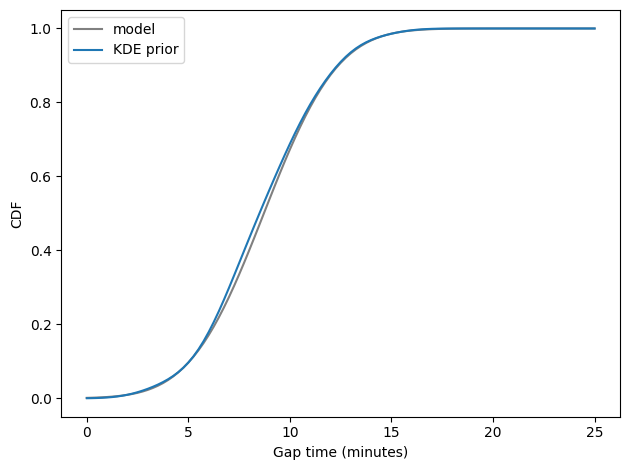

In [72]:
from scipy.stats import norm

xs = np.linspace(0, 25, 101)
ps = norm.cdf(xs, loc=m, scale=s)

plt.plot(xs, ps, color='gray', label='model')
cdf_prior.plot(label='KDE prior')

decorate(xlabel='Gap time (minutes)', ylabel='CDF')

The normal model fits the estimated density well, so it's probably a good choice to represent the prior distribution of gap times, as in the following model.

In [73]:
import pymc as pm  

# gap_time: Normal
# rate: Normal

def make_model2(n_obs=10):
    m, s = pmf_prior.mean(), pmf_prior.std()

    model = pm.Model()
    with model:
        gap_time = pm.Normal('gap_time', mu=m, sigma=s)
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Normal('rate', mu=2, sigma=0.1)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 3: Lognormal prior of gap times

With both of the previous models, we see some divergences in the sampling process, especially when `n_obs` is small, because that's when we explore the low end of the range of gap times, which is where the the KDE model and the normal model can be non-physical -- specifically, they can generate negative gap times.

To avoid that, we can use a prior distribution on a positive (or non-negative) domain. One natural choice is a lognormal distribution.
Many datasets that are well modeled by a normal distribution are also well modeled by a lognormal distribution, but the lognormal has two advantages: it is guaranteed to be positive, and it is usually skewed to the right, allowing the possibility of larger gap times.

To find the lognormal distribution that best fits the data, we'll use least squares optimization of the CDF.
The following function evaluates the CDF of the lognormal distribution with parameters `m` and `s` (which are not the mean and standard deviation of the distribution).

In [74]:
from scipy.stats import lognorm

def lognormal_cdf(xs, m, s):
    return lognorm.cdf(xs, s, scale=np.exp(m))

For a given set of parameters, the following function computes the CDF of a lognormal distribution and compares it to the CDF of the estimated densities, returning the differences  between the CDFs for a range of quantities.

In [75]:
def residuals(params, cdf_prior):
    m, s = params
    qs = cdf_prior.qs
    ps = lognormal_cdf(qs, m, s)
    return ps - cdf_prior.ps

Now we can find the parameters that minimized the area between the CDFs.

In [76]:
from scipy.optimize import least_squares

initial_guess = [2, 0.4]

result1 = least_squares(residuals, initial_guess, args=(cdf_prior,))
assert result1.success == True

In [77]:
m, s = result1.x
m, s

(2.121680868543866, 0.3296983754762425)

The following figure shows the best lognormal model and the CDF of the estimated density.

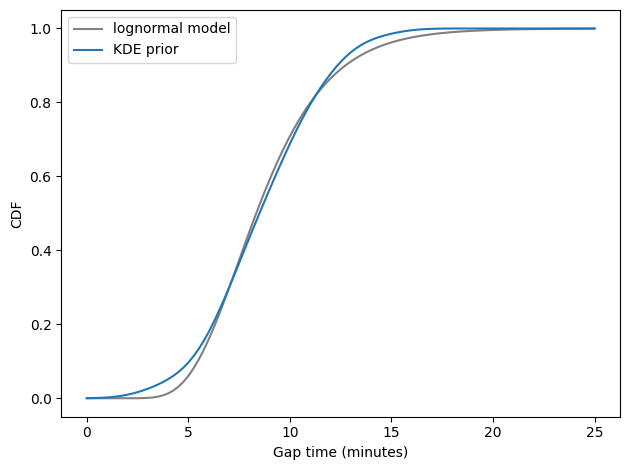

In [78]:
ps = lognormal_cdf(xs, m, s)
plt.plot(xs, ps, color='gray', label='lognormal model')

pmf_prior.make_cdf().plot(label='KDE prior')
decorate(xlabel='Gap time (minutes)', ylabel='CDF')

The lognormal model does not fit the estimated densities as well as the normal model, so there is a trade-off between the advantages of the lognormal model and fidelity to the data. 

In [79]:
import pymc as pm  

# gap_time: Lognormal
# rate: Normal

def make_model3(n_obs=10):
    m, s = result1.x

    model = pm.Model()
    with model:
        log_time = pm.Normal('log_time', mu=m, sigma=s)
        gap_time = pm.Deterministic('gap_time', pm.math.exp(log_time))
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Normal('rate', mu=2, sigma=0.1)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 4: gamma prior of rates

For the prior distribution of the arrival rate, we've been assuming so far that we have a precise estimate.
As a result, when `n_obs` is large, the model is compelled to conclude that the elapsed time is longer than usual -- it does not have the option to infer that the arrival rate might be larger than usual.

To add this capability to the model, we can increase the standard deviation of the normal model of arrival rates. But if we increase it too much, we run into the same problem we saw with the normal model of gap times -- it can go negative.

To avoid that, we can use a gamma distribution, which is guaranteed to be non-negative.
For a given mean and standard deviation, we can find the parameters of the gamma distribution.

In [80]:
mu = 2
sigma = 0.5

alpha = (mu/sigma)**2
beta = mu / sigma**2

alpha, beta

(16.0, 8.0)

And confirm that it works.

In [81]:
from scipy.stats import gamma

gamma_dist = gamma(a=alpha, scale=1/beta)
gamma_dist.mean(), gamma_dist.std()

(2.0, 0.5)

Here are the two models compared.
The gamma distribution is wider and slightly skewed to the right.

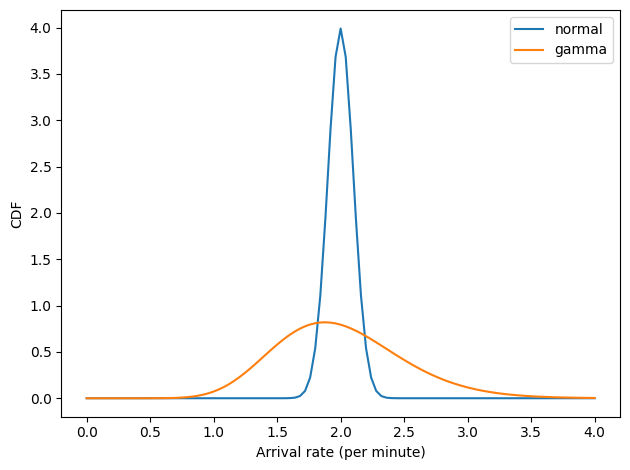

In [82]:
xs = np.linspace(0, 4, 101)
ps = norm.pdf(xs, 2, 0.1)
plt.plot(xs, ps, label='normal')

ps = gamma_dist.pdf(xs)
plt.plot(xs, ps, label='gamma')

decorate(xlabel='Arrival rate (per minute)', ylabel='CDF')

And here's a version of the model with the gamma distribution of arrival rates (and the lognormal model of gap times).

In [83]:
import pymc as pm  

# gap_time: Lognormal
# rate: Gamma


def make_model4(n_obs=10):
    m, s = result1.x

    model = pm.Model()
    with model:
        log_time = pm.Normal('log_time', mu=m, sigma=s)
        gap_time = pm.Deterministic('gap_time', pm.math.exp(log_time))
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Gamma('rate', alpha=alpha, beta=beta)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 5: Log-t prior of gap times

The normal model of gap times gives very low probabilities to very long gap times -- longer than 15 minutes. The lognormal model admits the possibility of somewhat longer gap times, but not by much. In the real world, we know that systems often operate in two modes: an ordinary mode where measurements are never more than a few standard deviations from the mean, and extraordinary modes where measurements might come from a different distribution entirely. In the train scenario, extraordinary modes include many kinds of disruption of service.

We can model these scenarios with multi-modal distributions, or mixtures of distributions -- but a versatile alternative is a Student-t distribution, which is similar to a normal distribution for values near the mean, but it can have a much thicker tail, admitting the possibility of extreme values.

A Student-t distribution on a log scale has the added advantage of being positive-valued, so let's try that.
The tail parameter, `nu`, determines the thickness of the tails.
When `nu` is larger than about 30, the Student-t converges to a normal distribution. Values below 10 yield long tails. Values below 5 yield very long tail.
For more on the properties of these distributions, and how they apply to real data, see Chapter 8 of [*Probably Overthinking It*](), or this [video from SciPy 2023]().

To find the best Student-t for the data, we'll use `least_squares` again.

In [84]:
nu = 7

In [85]:
from scipy.stats import t as student_t

def log_t_cdf(xs, m, s, nu):
    return student_t.cdf(np.log(xs), loc=m, scale=s, df=nu)

In [86]:
def residuals(params, cdf_prior):
    m, s = params
    qs = cdf_prior.qs
    ps = log_t_cdf(qs, m, s, nu=nu)
    return ps - cdf_prior.ps

In [87]:
from scipy.optimize import least_squares

initial_guess = [m, s]
result2 = least_squares(residuals, initial_guess, args=(cdf_prior,))
assert result2.success == True

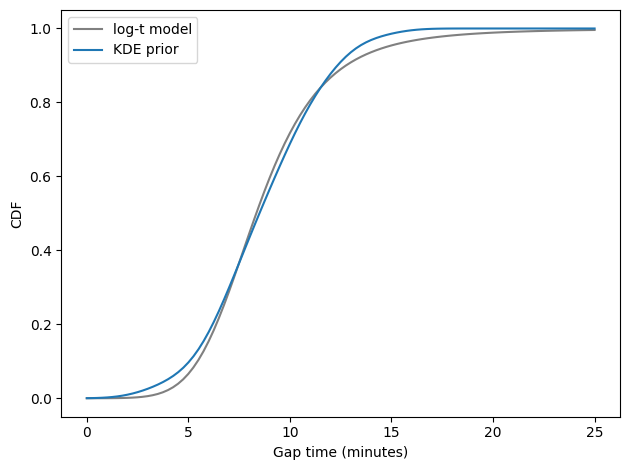

In [90]:
m, s = result2.x
qs = cdf_prior.qs
ps = log_t_cdf(qs, m, s, nu=nu)
plt.plot(xs, ps, color='gray', label='log-t model')

cdf_prior.plot(label='KDE prior')
decorate(xlabel='Gap time (minutes)', ylabel='CDF')

The Student-t model fits the data about as well as the lognormal model, and not as well as the normal model.
So again there is a trade-off between the amenable properties of the distributions and fidelity to the data.

In [30]:
import pymc as pm  

# gap_time: StudentT
# rate: Gamma

def make_model5(n_obs=10):
    m, s = result2.x

    model = pm.Model()
    with model:
        log_time = pm.StudentT('log_time', mu=m, sigma=s, nu=nu)
        gap_time = pm.Deterministic('gap_time', pm.math.exp(log_time))
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Gamma('rate', alpha=alpha, beta=beta)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Run the model

In the following cell, choose the model you want to run.

In [31]:
make_model = make_model5

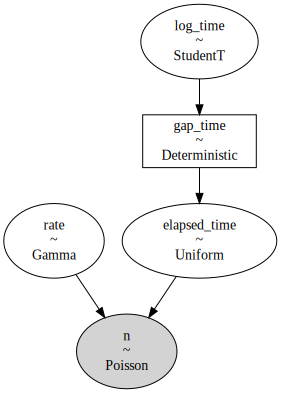

In [32]:
model = make_model(n_obs=10)
pm.model_to_graphviz(model)

Most of the models sample well with a wide range of `n_obs`.

In [33]:
with model:
    idata = pm.sample(500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


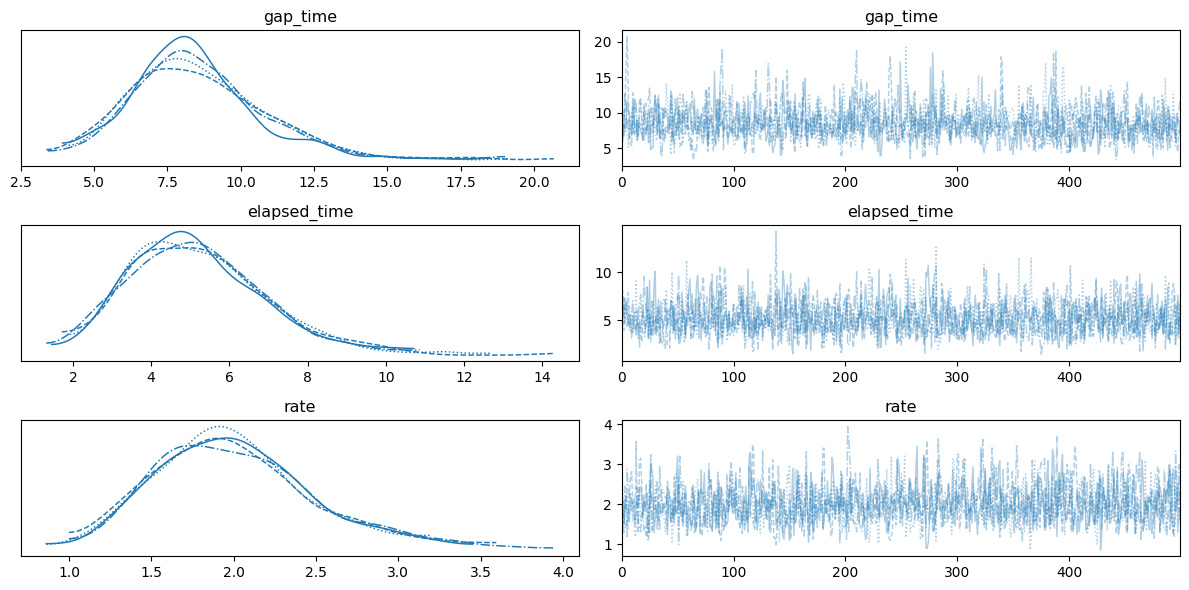

In [34]:
import arviz as az

var_names=['gap_time', 'elapsed_time', 'rate']

with model:
    az.plot_trace(idata, var_names=var_names)
    
plt.tight_layout()

Here are the posterior distributions for the key parameters.

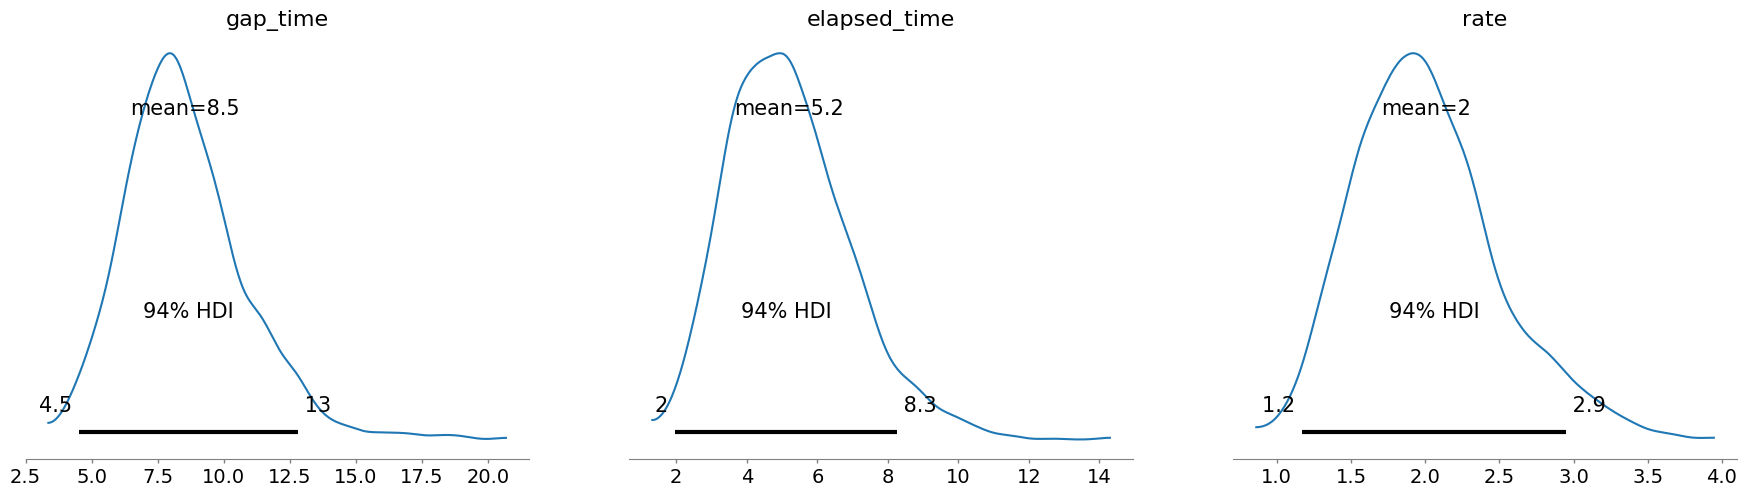

In [35]:
import arviz as az

with model:
    az.plot_posterior(idata, var_names=var_names)

To compute the posterior distribution of the remaining time -- which is what we are primarily interested in -- we have to extract the samples of `gap_time` and `elapsed_time` and subtract them elementwise.

In [ ]:
def get_sample(idata, var_name):
    return idata.posterior[var_name].values.flatten()

In [37]:
gap_times = get_sample(idata, 'gap_time')
np.mean(gap_times)

8.539538744486741

In [38]:
elapsed_times = get_sample(idata, 'elapsed_time')
np.mean(elapsed_times)

5.189812065879923

In [39]:
remaining_times = gap_times - elapsed_times
np.mean(remaining_times)

3.3497266786068174

Here's what the posterior distributions look like.

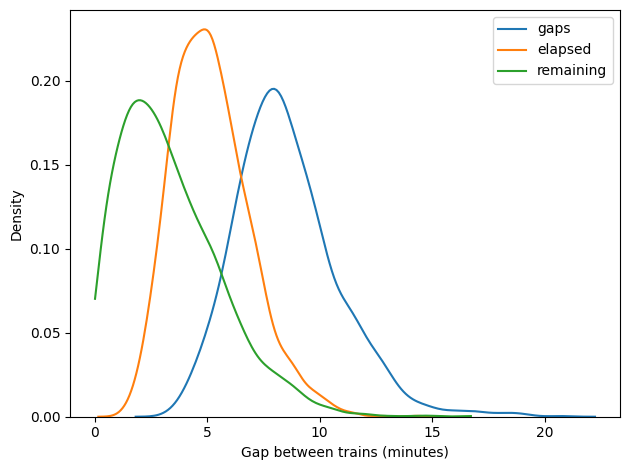

In [40]:
import seaborn as sns

sns.kdeplot(gap_times, label='gaps')
sns.kdeplot(elapsed_times, label='elapsed')
sns.kdeplot(remaining_times, label='remaining', cut=0)

decorate(xlabel='Gap between trains (minutes)')

## Correlations

In [36]:
rates = get_sample(idata, 'rate')
np.mean(rates)

2.0043159773409984

In [41]:
np.corrcoef([gap_times, elapsed_times, rates])

array([[ 1.        ,  0.39682275, -0.18816675],
       [ 0.39682275,  1.        , -0.53686235],
       [-0.18816675, -0.53686235,  1.        ]])

In [42]:
def joint_contour(x, y):
    data = np.vstack([x, y])
    kde = gaussian_kde(data)

    xs = np.linspace(x.min(), x.max(), 101)
    ys = np.linspace(y.min(), y.max(), 101)
    X, Y = np.meshgrid(xs, ys, indexing='ij')

    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_values = kde(positions).reshape(X.shape)

    plt.contour(X, Y, kde_values, cmap='Blues')

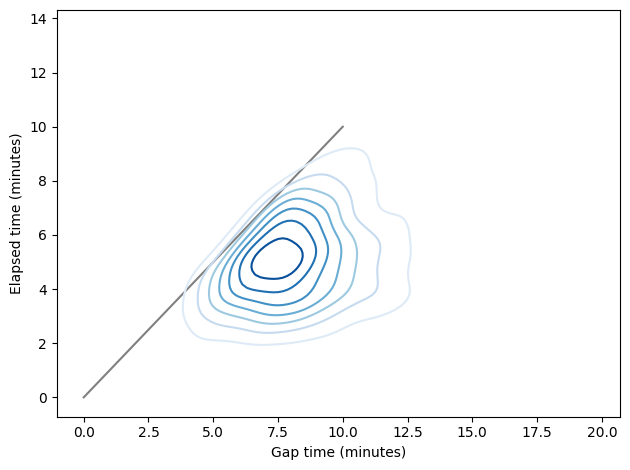

In [43]:
plt.plot([0, 10], [0, 10], color='gray')
joint_contour(gap_times, elapsed_times)
decorate(xlabel='Gap time (minutes)', ylabel='Elapsed time (minutes)')

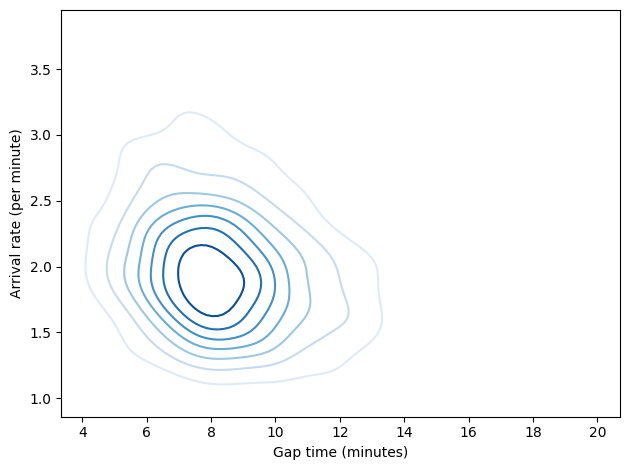

In [44]:
joint_contour(gap_times, rates)
decorate(xlabel='Gap time (minutes)', ylabel='Arrival rate (per minute)')

## Run with a range of n_obs

In [45]:
def run_model(make_model_func):
    """
    """
    gap_df = pd.DataFrame(dtype='float')
    elapsed_df = pd.DataFrame(dtype='float')
    remaining_df = pd.DataFrame(dtype='float')
    rate_df = pd.DataFrame(dtype='float')

    # run the model with a range of n_obs
    for n_obs in [2, 5, 10, 20, 30, 40]:
        print(n_obs)
        model = make_model_func(n_obs)
        with model:
            idata = pm.sample(500, tune=500)

        gap_times = get_sample(idata, 'gap_time')
        gap_df[n_obs] = gap_times

        elapsed_times = get_sample(idata, 'elapsed_time')
        elapsed_df[n_obs] = elapsed_times

        remaining_df[n_obs] = gap_times - elapsed_times

        rate_df[n_obs] = get_sample(idata, 'rate')

    # save the results in an HDF file
    model_name = make_model_func.__name__.split('_')[1]
    varnames = ['gap', 'elapsed', 'remaining', 'rate']
    dataframes = [gap_df, elapsed_df, remaining_df, rate_df]

    for varname, df in zip(varnames, dataframes):
        key = f'{model_name}_{varname}'
        df.to_hdf('redline.hdf', key=key)

In [46]:
make_model_funcs = [make_model1, make_model2, make_model3, make_model4, make_model5]

for make_model_func in make_model_funcs:
    run_model(make_model_func)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [47]:
def get_result(model_name, varname):
    key = f'{model_name}_{varname}'
    return pd.read_hdf('redline.hdf', key=key)

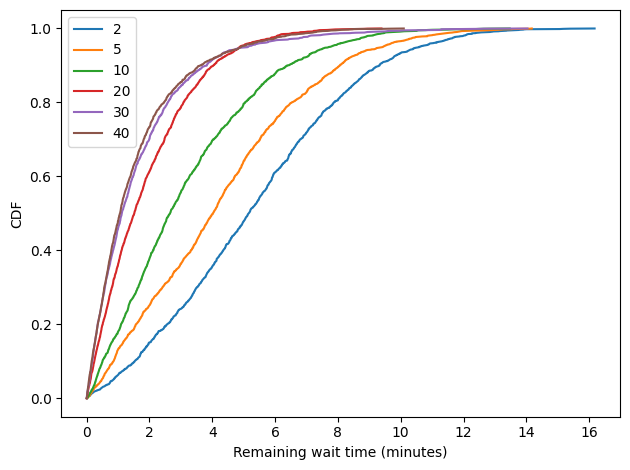

In [48]:
from empiricaldist import Cdf

def plot_cdfs(model_name, varname):
    df = get_result(model_name, varname)
    
    for n_obs, sample in df.items():
        cdf = Cdf.from_seq(sample)
        cdf.plot(label=n_obs)

    decorate(ylabel='CDF')
    
plot_cdfs('model1', 'remaining')
decorate(xlabel='Remaining wait time (minutes)')

In [49]:
def plot_model_results(models, varname):
    for i in models:
        model_name = f'model{i}'
        df = get_result(model_name, varname)
        df.mean().plot(label=model_name)

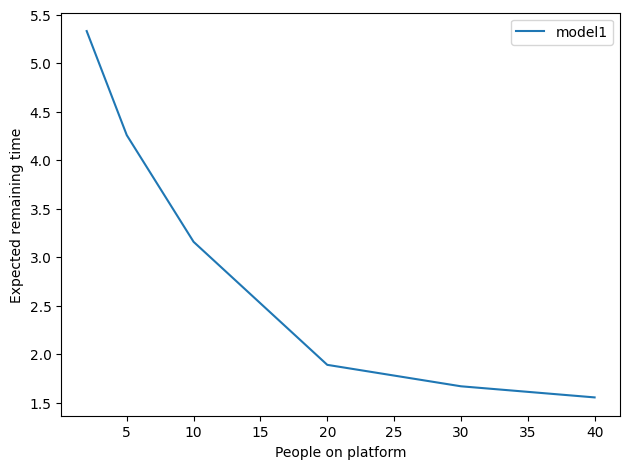

In [50]:
plot_model_results([1], 'remaining')
decorate(xlabel='People on platform', ylabel='Expected remaining time')

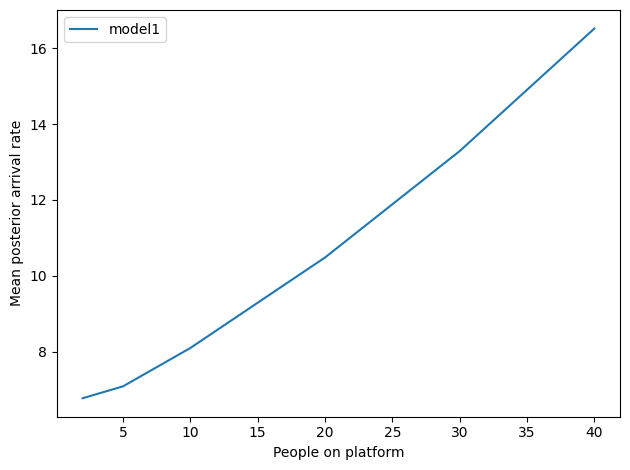

In [51]:
plot_model_results([1], 'gap')
decorate(xlabel='People on platform', ylabel='Mean posterior arrival rate')

## Compare models

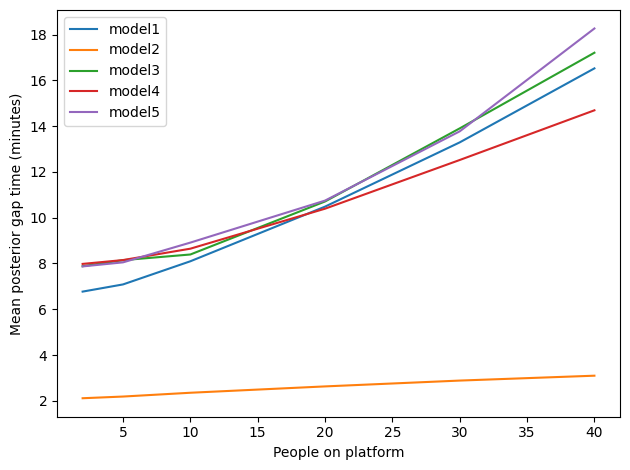

In [52]:
all_models = range(1, 6)

plot_model_results(all_models, 'gap')
decorate(xlabel='People on platform', ylabel='Mean posterior gap time (minutes)')

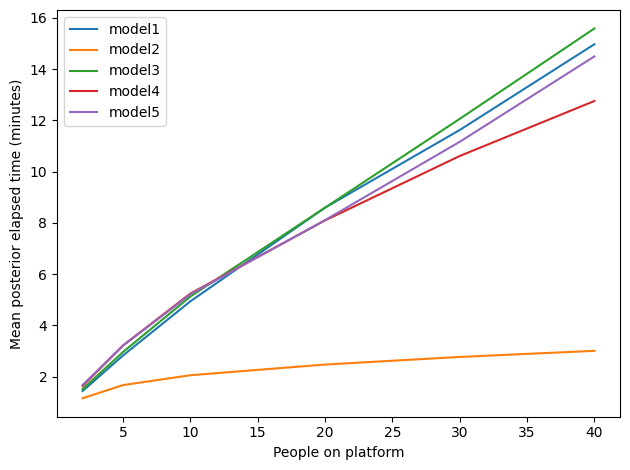

In [53]:
plot_model_results(all_models, 'elapsed')
decorate(xlabel='People on platform', ylabel='Mean posterior elapsed time (minutes)')

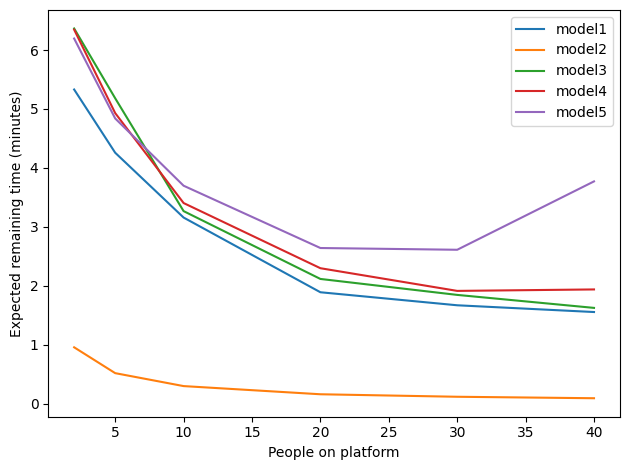

In [54]:
plot_model_results(all_models, 'remaining')
decorate(xlabel='People on platform', ylabel='Expected remaining time (minutes)')

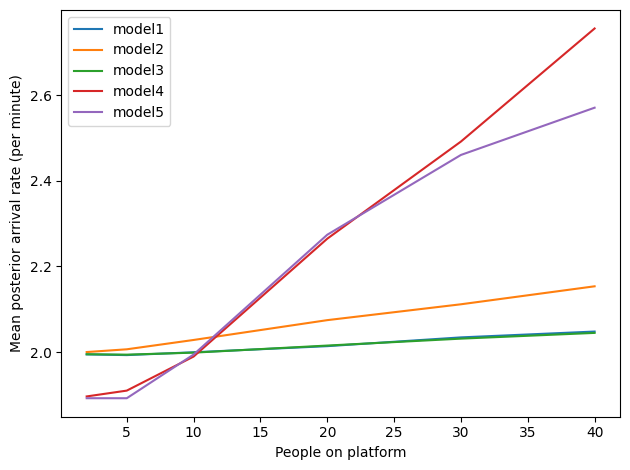

In [55]:
plot_model_results(all_models, 'rate')
decorate(xlabel='People on platform', ylabel='Mean posterior arrival rate (per minute)')

Think Bayes, Second Edition

Copyright 2024 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)